In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)

from foods.meals import molly_meals, paps_meals, fabian_meals, test_meals
from foods.dashboard import read_raw, find_food, calc_nuts, make_dashboard, make_nutrient_graphs

%load_ext autoreload
%autoreload 2

In [2]:
def str_to_numeric(df):
    cols = ['calories', 'fat', 'carbs', 'sugar', 'fiber', 'protein']
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    return df

def str_to_lower(df):
    cols = df.columns[df.dtypes.eq('object')]
    df[cols] = df[cols].applymap(str.lower)
    return df

columns = {
    'Name': 'ingredient',
    'Category': 'category',
    'Matrix unit': 'units',
    'Energy, kilocalories (kcal)': 'calories',
    'Fat, total (g)': 'fat',
    'Carbohydrates, available (g)': 'carbs',
    'Protein (g)': 'protein',
    'Sugars (g)': 'sugar',
    'Dietary fibres (g)': 'fiber',
}

path = './data/Swiss-food-composition-database-V6.1.xlsx'
    
foods = (
    pd.read_excel(path, skiprows=2, usecols=columns)
    .rename(columns=columns)
    .pipe(str_to_numeric)
    .pipe(str_to_lower)
)

print(foods.shape)
foods.head()

(1018, 9)


,ingredient,category,units,calories,fat,carbs,sugar,fiber,protein
0,agar agar,various/gelling and binding agents,per 100g edible portion,160,0.2,0.0,NaN,74.1,2.4
1,agave syrup,sweets/sugar and sweeteners,per 100g edible portion,293,0.0,73.1,NaN,0.0,0.2
2,almond,"nuts, seeds and oleaginous fruit",per 100g edible portion,593,49.9,4.0,3.9,13.0,25.5
3,"almond, dry roasted, salted","savoury snacks/salted nuts, seeds and kernels",per 100g edible portion,634,52.1,10.3,4.9,10.9,25.4
4,"almond, roasted, salted","savoury snacks/salted nuts, seeds and kernels",per 100g edible portion,649,55.2,7.2,4.6,10.5,25.6


In [3]:
def find_item(regex, cat=False):
    if not cat:
        subset = foods.ingredient.str.contains(regex)
    else:
        subset = foods.category.str.contains(regex)
    return foods[subset]
        

find_item('coffee')

,ingredient,category,units,calories,fat,carbs,sugar,fiber,protein
229,"coffee, black, no sugar added",non-alcoholic beverages/coffee,per 100ml food volume,2,0.0,0.3,0.0,0.1,0.1
230,coffee cream uht,fats and oils/cream;milk and dairy products/cream and butter,per 100g edible portion,161,15.0,3.8,3.8,0.0,2.6
231,"coffee, instant, powder",non-alcoholic beverages/coffee,per 100g edible portion,253,NaN,42.6,3.6,19.1,11.2
232,"coffee with coffee cream, no sugar added",non-alcoholic beverages/coffee,per 100ml food volume,13,1.1,0.5,0.3,0.1,0.3
306,"espresso with coffee cream, no sugar added",non-alcoholic beverages/coffee,per 100g edible portion,28,2.5,0.8,0.7,0.1,0.5
715,"ristretto with coffee cream, no sugar added",non-alcoholic beverages/coffee,per 100g edible portion,47,4.3,1.3,1.1,0.1,0.8


In [4]:
meals = {

    'Lunch': {
        'coconut fat': 0.2,
        'scrambled eggs, prepared': 2.4,
        'mushroom, stewed (without addition of fat and salt)': 0.5,
        'spinach, steamed (without addition of salt)': 0.5,
        
        'iceberg lettuce, raw': 0.5,
        'avocado, fresh': 1.6,
        'bell pepper, red, raw': 0.5,
        'seeds, kernels, nuts (average), unsalted': 0.2,
        'olive oil': 0.2,
        'vinegar': 0.1,
    },
    
    'Snack': {
        'coconut fat': 0.2,
        'cocoa powder': 0.05,
        'coffee, black, no sugar added': 1,
    },
}

In [5]:
foods

,ingredient,category,units,calories,fat,carbs,sugar,fiber,protein
0,agar agar,various/gelling and binding agents,per 100g edible portion,160,0.2,0.0,NaN,74.1,2.4
1,agave syrup,sweets/sugar and sweeteners,per 100g edible portion,293,0.0,73.1,NaN,0.0,0.2
2,almond,"nuts, seeds and oleaginous fruit",per 100g edible portion,593,49.9,4.0,3.9,13.0,25.5
3,"almond, dry roasted, salted","savoury snacks/salted nuts, seeds and kernels",per 100g edible portion,634,52.1,10.3,4.9,10.9,25.4
4,"almond, roasted, salted","savoury snacks/salted nuts, seeds and kernels",per 100g edible portion,649,55.2,7.2,4.6,10.5,25.6
...,...,...,...,...,...,...,...,...,...
1013,ziger white,milk and dairy products/fresh cheese and curds,per 100g edible portion,122,7.2,3.3,3.3,0.0,10.9
1014,"zucchini piccata, prepared",prepared dishes/other savoury dishes,per 100g edible portion,151,11.3,6.4,2.0,1.0,5.4
1015,"zucchini, raw",vegetables/fresh vegetables,per 100g edible portion,19,0.2,2.0,1.9,1.0,1.8
1016,"zucchini slices, breaded, prepared",prepared dishes/other savoury dishes,per 100g edible portion,128,5.6,13.5,2.2,1.6,5.1


In [6]:
def get_meal_data(meal):

    # Grams data
    data = (foods[foods.ingredient.isin(meal)].copy()
            .set_index('ingredient')
            .drop(['units', 'category', 'calories', 'sugar'], axis=1))
    portion = data.index.map(meal)
    grams = data.multiply(portion, axis=0)
        
    # Calories data
    calories = grams.copy()
    calories['fat'] = calories.fat * 9
    calories['carbs'] = calories.carbs * 4
    calories['protein'] = calories.protein * 4
    calories['fiber'] = calories.fiber * 2
    
    return {'grams': grams, 'cals': calories}

In [42]:
# Calc grams and calories for all meals
meal_data = {meal: get_meal_data(meals[meal]) for meal in meals}

# Add gram and calorie totals
totals = {}
for measure in ['cals', 'grams']:
    pieces = []
    for meal in meal_data.keys():
        pieces.append(meal_data[meal][measure])
    total = pd.concat(pieces).groupby(level=0).sum()
    totals[measure] = total

meal_data['Total'] = totals

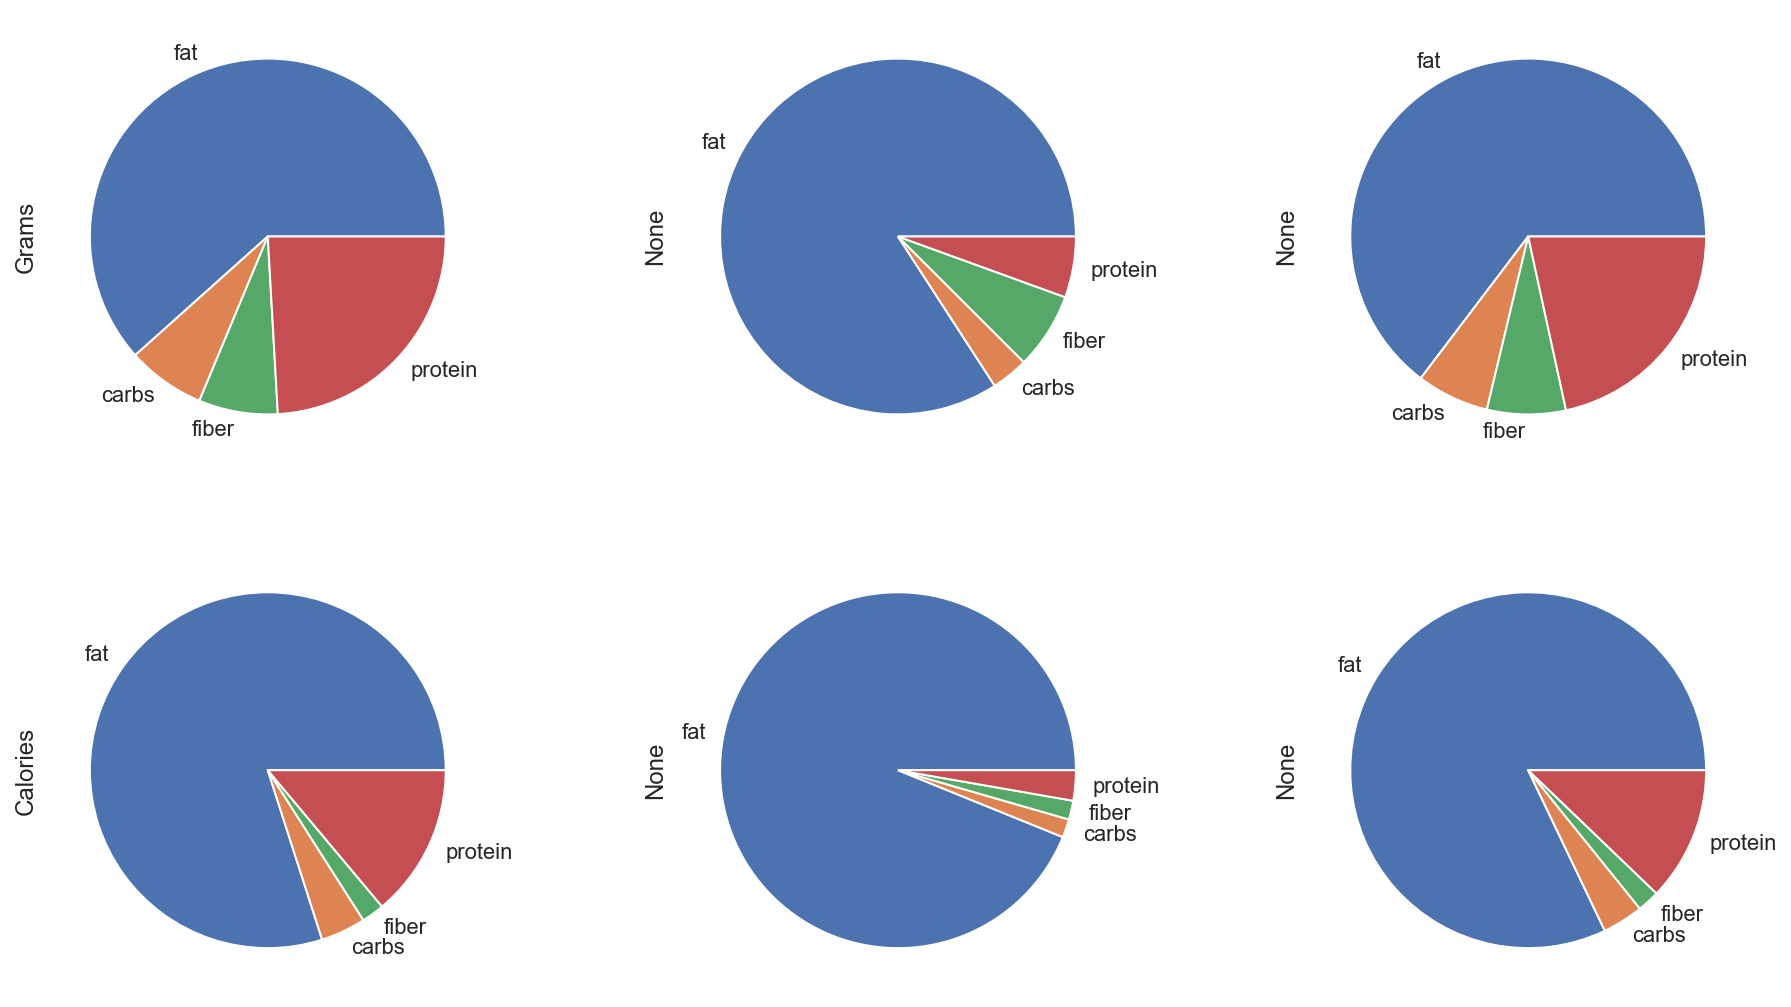

In [41]:

num_meals = len(meal_data)
fig, ax = plt.subplots(2, num_meals)

for i, meal in enumerate(meal_data):
    meal_data[meal]['grams'].sum(0).plot(kind='pie', ax=ax[0, i])
    meal_data[meal]['cals'].sum(0).plot(kind='pie', ax=ax[1, i])

# ax0.set_title('Lunch')
ax[0, 0].set_ylabel('Grams')
ax[1, 0].set_ylabel('Calories');